<a href="https://colab.research.google.com/github/vanepsm/cs5262-cyclist-crashes-nyc/blob/main/nyc_cyclist_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating cyclist accidents in New York City
*Aaron Vaneps: CS5262*

## Background

### Introduction
**The objective of this project is to identify factors contributing to cyclist injuries and fatalities.**

With the increasing popularity of bicycles and e-bikes, it's imperative for drivers, cyclists, pedestrians, and policymakers to recognize the risks associated with cyclists sharing our public roadways and to minimize cyclist injuries and fatalities.

### Literature review

The [National Safety Council](https://injuryfacts.nsc.org/home-and-community/safety-topics/bicycle-deaths/) reports a 37% increase in preventable cycling deaths over the past decade, making up 2% of all motor vehicle fatalities. Understanding the factors contributing to these incidents is crucial for reducing cyclist deaths and injuries.

Additionally, [e-bikes are gaining popularity as low cost / low carbon transport systems](https://www.sciencedirect.com/science/article/pii/S2590198221000543), surpassing sales of electric cars. The [New York Times](https://www.nytimes.com/2021/11/08/business/e-bikes-urban-transit.html), [PBS](https://www.pbs.org/newshour/show/e-bike-popularity-is-surging-creating-regulatory-challenges-on-u-s-roads) and many other publications have highlighted the rise of e-bikes and the accompanying safety challenges. This new wave of cyclists introduces distinct dynamics on the roads as they take ownership of vehicles with higher top speeds and greater ranges.

The increasing accidents involving motor vehicles and cyclists present a growing problem worldwide. As transportation solutions evolve, it's essential to gain insights into these trends to effectively address the emerging challenges.


### Challenges
Motor vehicle accidents are complicated events, and accidents between motor vehicles and bicycles are more complex yet. Many data points that we wish we knew about cyclist fatalities are not known. Was the cyclist riding on the road, sidewalk or bike lane? Was the cyclist wearing a helmet? Were there adverse weather conditions present? None of these data points are reported in the New York City vehicle collision dataset.

Other data elements that do exist, like contributing factors to the accident or vehicle types, have dozens (maybe hundreds) of possible values.  How can we analyze the data in a way that teases the signal from the noise? I'm hoping this project can help do just that.

## Project Description

### Topic
Our topic will focus on motor vehicle crashes that involve cyclist injuries or deaths, and attempt to analyze these data to determine what factors are correlated with cyclist injuries and fatalities. By training data models on this dataset I hope to learn patterns, relationships and structures from the data. I also hope to be able to enhance decision making for cyclists, motorists and policymakers.

This is also my first machine learning project, so I hope to actually learn how to do all those cool things I just said.



### Outcome Predictions

I have several predictions I would like to test with this data.  A few are as follows:
- **Trucks are more deadly than cars.** I own a large truck now, and I believe them to be more dangerous than cars I've owned in the past.  Visibility is limited, they have much greater mass, and the height of a truck ought to hit a cyclist full on, rather than the "up and over" type of glancing impact of a car. If this prediction is true then the liklihood of death instead of injury with a truck involved in the accident will be much greater than other vehicles.
- **E-bikes are less dangerous than bikes.** Of all my predictions, this is the one I'm least certain about. E-bikes require less exhertion, and the rider is more often in an upright position.  Which should allow the rider to be more observant of his environment. I believe e-bike accidents will have fewer fatalities by percentage than standard bicycles.
- **Distracted driving kills.** I expect the various forms of distracted driving (cell phones, headphones, etc...) will outweight all other causes for both injury and death.

### Data
This project seeks to gain insights into vehicle accidents involving cyclists extracted from the New York City vehicle collisions dataset.
> https://catalog.data.gov/dataset/motor-vehicle-collisions-crashes

A subset of the data pertaining only to cyclist accidents has been extracted and is available here:
> https://drive.google.com/file/d/1CFaRXe3Y6PWHpYOoGD7qih6-1oWzUi0e/view

#### Data sub-selection criteria
The original data set contains over two million rows, and encapsulates a broad spectrum of vehicle collisions. In order to narrow this dataset down to a size appropriate for CS5262 the following was done:
- Import the original CSV data to a relational database for refinement.
- Idenify a subset of rows:
 - Include only the rows with cyclist injuries or fatalities
 - Remove all rows with more than 3 vehicles involved in the crash
 - Remove all rows with a null or empty zip code
- Identify a subset of columns:
 - Exclude all columns with details about a 4th or 5th vehicle, as there aren't very many and add too many columns to our dataset
 - Exclude duplicate latitude/longitude columns
- Export the subset data to a new CSV for use in this project.

## Performance Metrics

### Binary Classification
Ultimately I realize I may have to just pick one attribute for binary classification, but there are 3 that I find interesting:


- **Injured vs. Killed.** I would like to classify observations into two classes. "Cyclist Injured" vs "Cyclist Killed".
- **E-bike or not?** I would like to classify e-bikes vs. traditional bikes as the recent rise in e-bike popularity may be largely unexplored.
- **Distracted driving vs. all others** I would like to classify all the contributing factors into "distracted driving" vs "not distracted driving" and then create a binary classification to differentiate those two.

### Clustering
I am hoping to extract meaningful patterns from these data, some of which may include:
- **Physical location.** Intuition tells us there are locations that are more dangerous for cyclists than others. Intersections, curves, congested spaces, etc... What role does location play in injuries and fatalities?
- **Time.** It seems likely that certain times will see more accidents than others. Around what times do fatalities tend to cluster?
- **Types of vehicles involved.** It's possible that certain vehicle types will result in more accidents overall, or perhaps result in death more often than injury. What kind of vehicles are more prone to injuries? What are more prone to fatalities?
- **Types of bikes.** Do newer alternative types of bicycles like the e-bike pose a greater risk for death? What is the breakdown of e-bike deaths and injuries versus traditional bikes?
- **Contributing factors for the accident.** What types of contributing factors are more likely to result in injury or death? Distracted driving, improper use of passing lanes, alcohol intoxication, etc...?

In [1]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# map visualizations
!pip install descartes
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

#file downloading utilities
import gcsfs
!pip install gdown
import gdown

#machine learning
!pip install mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from libpysal.weights import KNN
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import set_config
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Import the Pipeline from imblearn to handle SMOTE correctly
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 31.0 MB/s eta 0:00:00


# Load data
Here we will load the data into python using pandas and read it in as a dataframe.

In [2]:
# load data from google drive: note the need to reference directly by ID
#url = 'https://drive.google.com/file/d/1CFaRXe3Y6PWHpYOoGD7qih6-1oWzUi0e/view?usp=sharing'
#url='https://drive.google.com/uc?id=' + url.split('/')[-2]

url = 'https://storage.googleapis.com/cs5262-data/cyclist-injuries-and-deaths-nyc.csv'
df = pd.read_csv(url)

In [3]:
# download our new york city shape ZIP file and unzip the shape files inside it
#street_map_zip_url = 'https://drive.google.com/uc?id=14w9K-pqMjRQed9J5pqXfLFEZ_ISzAbXj'
street_map_zip_url = 'https://storage.googleapis.com/cs5262-data/street_map.zip'
output = 'street_map.zip'
gdown.download(street_map_zip_url, output, quiet=False)
!unzip -o street_map.zip

Downloading...
From: https://storage.googleapis.com/cs5262-data/street_map.zip
To: /content/street_map.zip
100%|██████████| 5.33M/5.33M [00:00<00:00, 27.3MB/s]


Archive:  street_map.zip
  inflating: geo_export_d2b45f2c-bc03-4aeb-9e9e-9d452a5d9556.dbf  
  inflating: geo_export_d2b45f2c-bc03-4aeb-9e9e-9d452a5d9556.shp  
  inflating: geo_export_d2b45f2c-bc03-4aeb-9e9e-9d452a5d9556.shx  


In [4]:
# display the first few rows of our data for informational purposes
display(df.head())

crash-date crash-time  zip-code   latitude  longitude  on-street-name  \
0  2021-12-14      12:54     11217  40.687534 -73.977500   FULTON STREET   
1  2022-04-24      15:35     10019  40.767242 -73.986206  WEST 56 STREET   
2  2021-12-09      23:15     11218  40.640835 -73.989670       12 AVENUE   
3  2021-12-08      19:30     10022  40.761750 -73.968990             NaN   
4  2021-12-08      12:00     10011  40.736614 -73.995100             NaN   

    cross-street-name           off-street-name  persons-injured  \
0  SAINT FELIX STREET                       NaN                1   
1            9 AVENUE                       NaN                1   
2           41 STREET                       NaN                1   
3                 NaN  127       EAST 58 STREET                1   
4                 NaN  44        WEST 14 STREET                1   

   persons-killed  ...  cyclists-killed  motorists-injured  motorists-killed  \
0               0  ...                0                  0                 0   
1               0  ...                0                  0                 0   
2               0  ...                0                  0                 0   
3               0  ...                0                  0                 0   
4               0  ...                0                  0                 0   

    contributing-factor-vehicle-1   contributing-factor-vehicle-2  \
0                     Unspecified                     Unspecified   
1         View Obstructed/Limited                     Unspecified   
2  Driver Inattention/Distraction  Driver Inattention/Distraction   
3           Following Too Closely  Reaction to Uninvolved Vehicle   
4  Passing or Lane Usage Improper                     Unspecified   

   contributing-factor-vehicle-3 collision-id  \
0                            NaN      4487052   
1                            NaN      4521853   
2                            NaN      4485355   
3                            NaN      4484852   
4                            NaN      4485542   

                   vehicle-type-code-1 vehicle-type-code-2  \
0                                Sedan                Bike   
1  Station Wagon/Sport Utility Vehicle                Bike   
2                                Sedan                Bike   
3  Station Wagon/Sport Utility Vehicle                Bike   
4                            Box Truck                Bike   

   vehicle-type-code-3  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  

[5 rows x 23 columns]

# Feature Engineering

These features will be created using PANDAS data frame manipulation.


| Feature | Description |
|---------|-------------|
| cyclist-fatalities | True if there is a cyclist fatality, false if an injury |
| accident-at-intersection | True if there is an accident at an intersection, false if it is on a roadway. |
| e-bike | True if it's an e-bike, false if its not. |

We have a number of features we will want to create based on the values of one or more existing features.  Let's do that here.

In [5]:
# throw out rows with invalid coordinates
df = df[df['latitude'] != 0.0]
df = df[df['longitude'] != 0.0]

# create a boolean value for cyclist fatalities
df['cyclist-fatalities'] = df['cyclists-killed'] != 0

# create a new feature to decide if the accident is on an intersection or not
df['accident-at-intersection'] = df['off-street-name'].isnull()

# create a feature to clearly articulate if this accident involves an e-bike or not
df['e-bike'] = (df['vehicle-type-code-1'].str.lower() == "e-bike") | (df['vehicle-type-code-2'].str.lower() == "e-bike") | (df['vehicle-type-code-3'].str.lower() == "e-bike")

# -------------------------------
# Functions
# -------------------------------
def autopct_format(values):
  def my_format(pct):
    total = sum(values)
    val = int(round(pct*total/100.0))
    return '{:.1f}%\n({v:d})'.format(pct, v=val)
  return my_format


def evaluate_model_performance(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("MODEL: " + model_name)
    print(f"Model accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print("")


# Data Examination Questions

## Q1

###  Q - How many cyclists are dying versus being injured?

I really want to understand to what degree cyclist deaths are a problem.  If there are very few deaths relative to injuries then the focus of interventions may change.

False    38204
True       144
Name: cyclist-fatalities, dtype: int64

([<matplotlib.patches.Wedge at 0x7b0f988b2470>,
 [Text(-1.0999234581939878, 0.012976367541770159, 'False'),
  Text(1.099923457880762, -0.012976394091885918, 'True')])

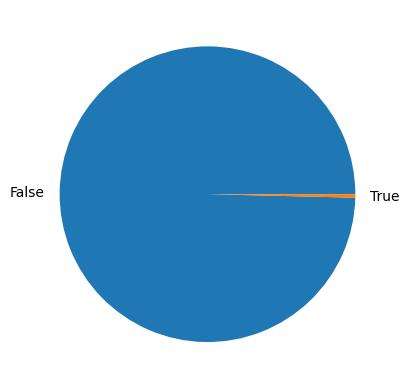

In [6]:
# Creating a pie chart to visualize cyclists deaths versus injuries
fatality_counts = df['cyclist-fatalities'].value_counts()
display(fatality_counts)

plt.pie(fatality_counts, labels=fatality_counts.index, shadow = False)


### A - Deaths numbers are relatively small

We see 38,325 injuries versus 144 deaths.  This may mean we should focus on reducing the total number of injuries rather than attempting to prevent deaths.  It's important to point out that reducing total injuries may also reduce deaths.

## Q2

### Q - Where are accidents happening?

These data rows contain latitude and longitude information about where the accident occurred. Let's plot those out in a way that gives us some kind of reference map to show where danger areas lie.  We will first pull down a shape file that shows all the streets in New York City, then superimpose our accidents on top of that. Blue dots will indicate injuries, red triangles will indicate fatalities.

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


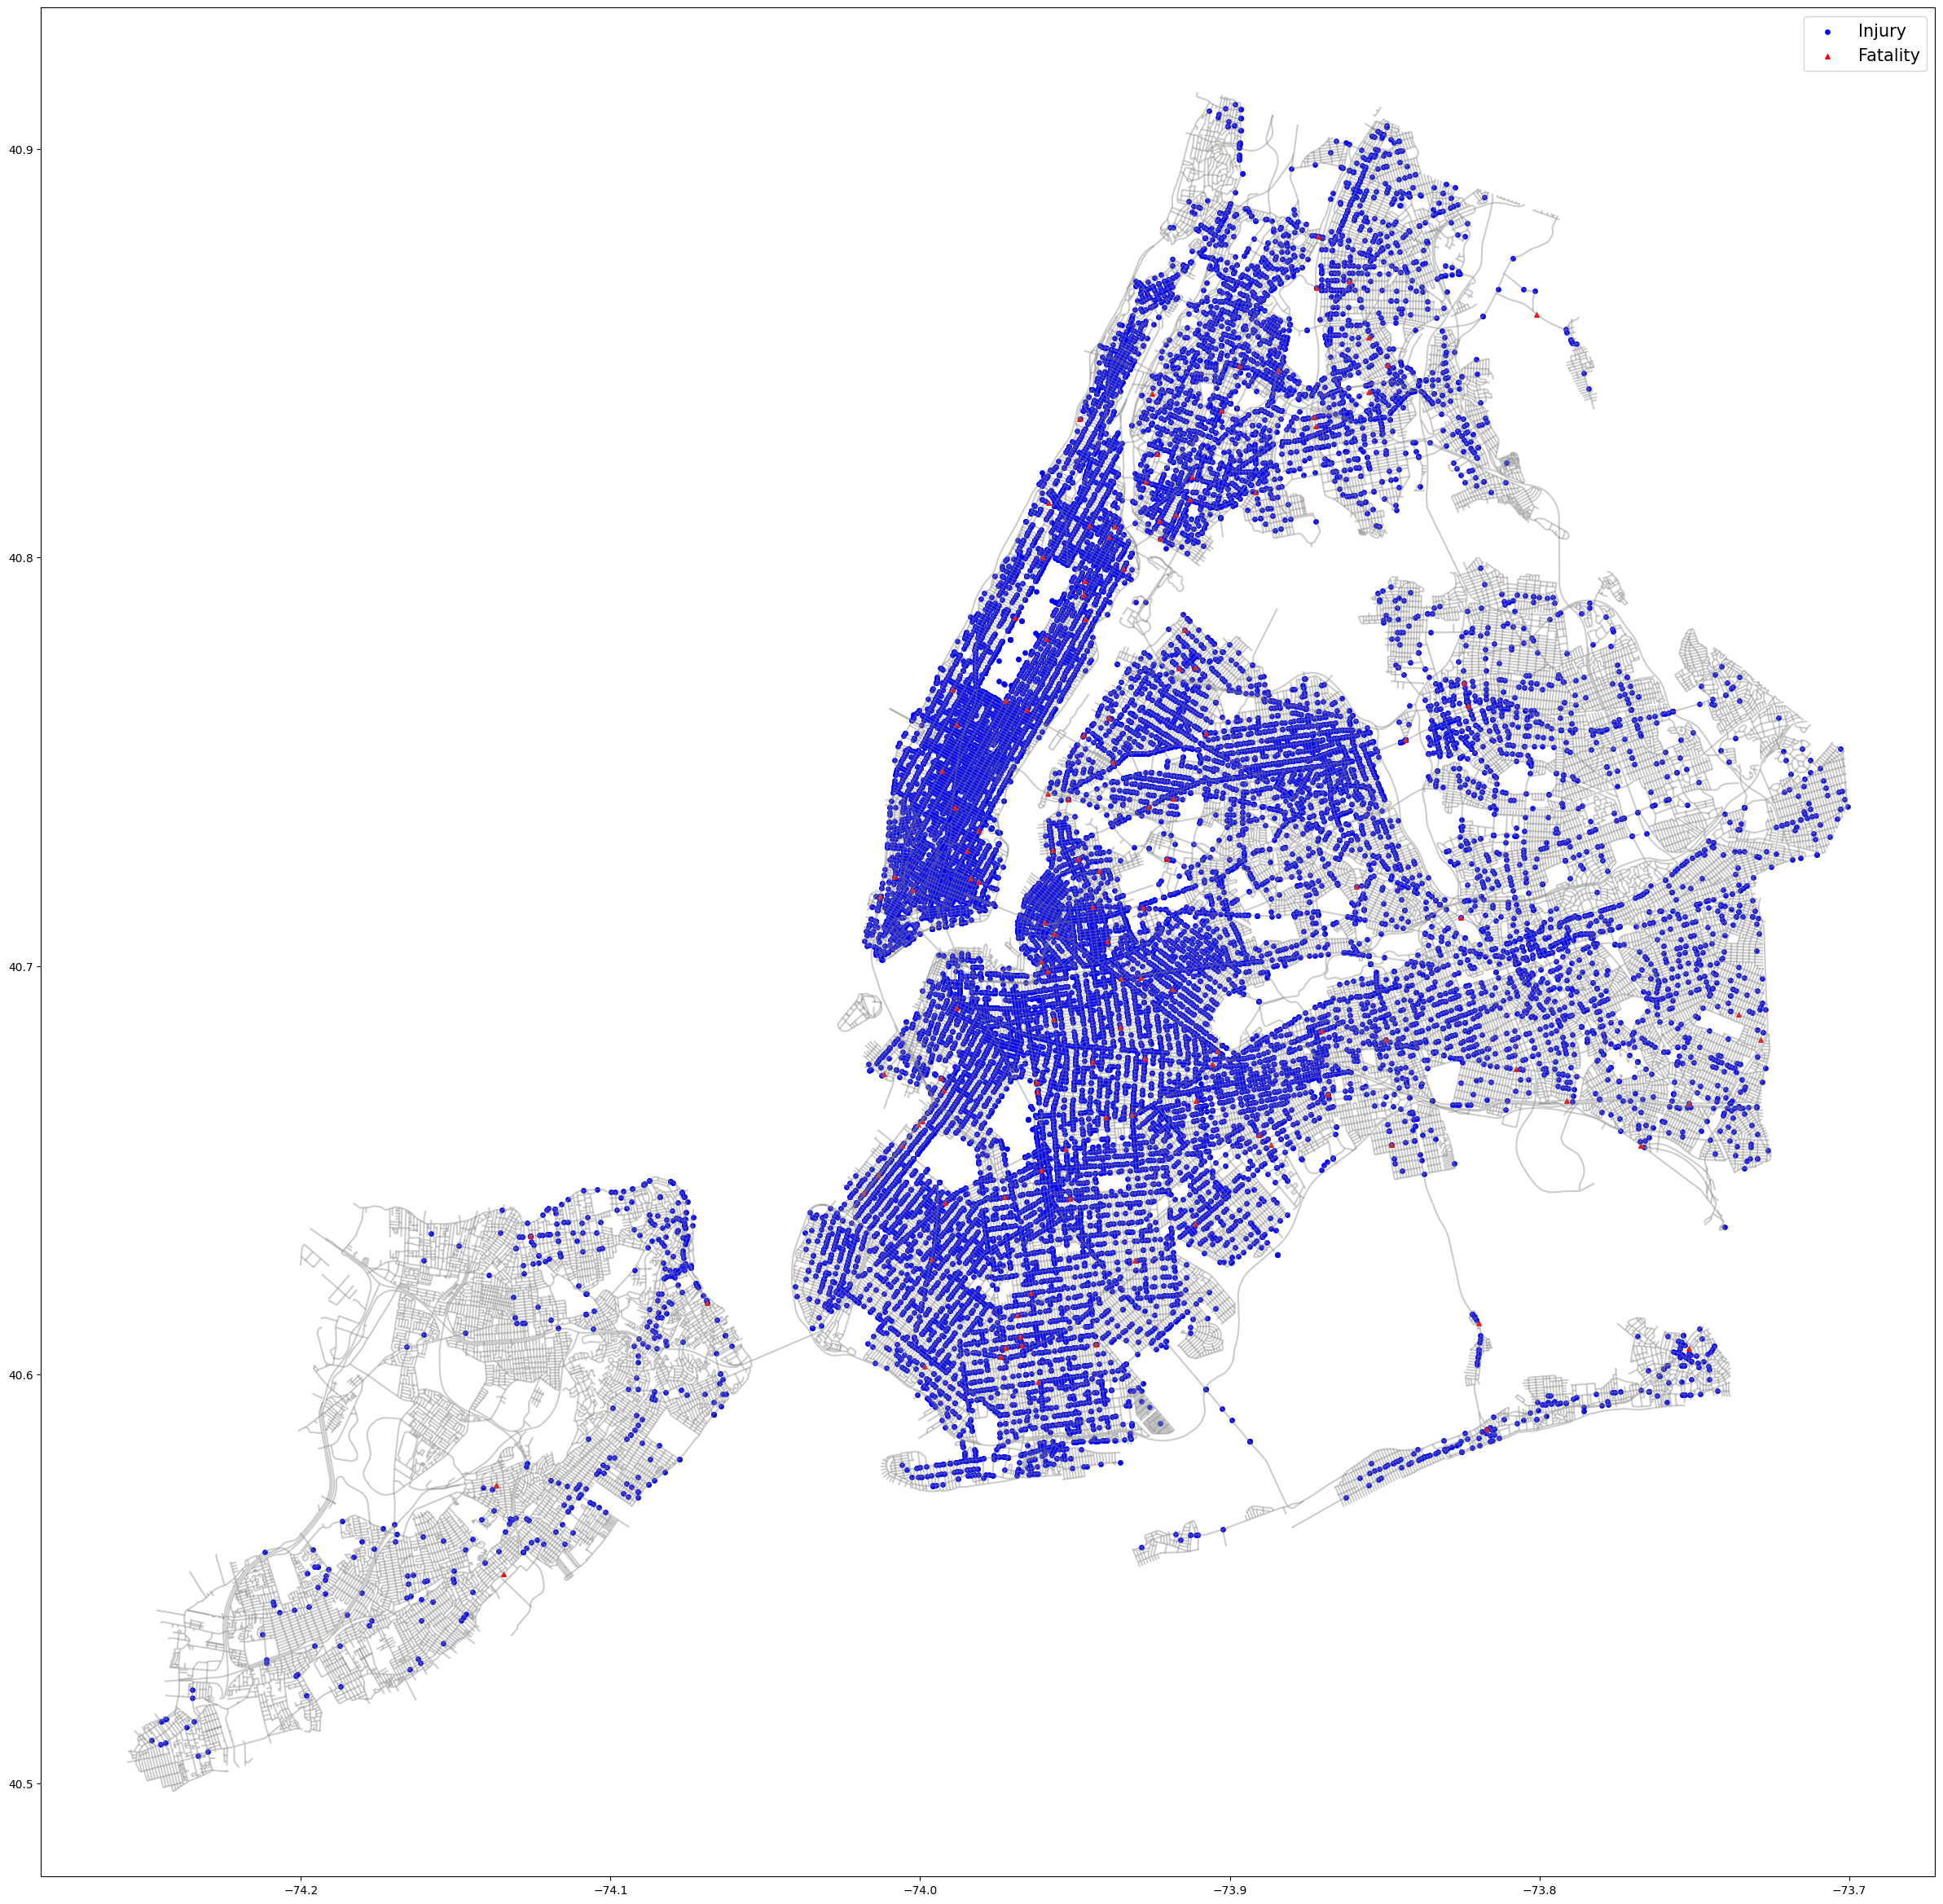

In [7]:
# cool, now let's grab a shape file, plot that and then superimpose our accidents on top of that as points
street_map = gpd.read_file('geo_export_d2b45f2c-bc03-4aeb-9e9e-9d452a5d9556.shp')
#fig, ax = plt.subplots(figsize=(30,30))
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
fig, ax = plt.subplots(figsize=(30,30))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['cyclist-fatalities'] == False].plot(ax=ax,
                                       markersize=15,
                                       color='blue',
                                       marker='o',
                                       label='Injury')
geo_df[geo_df['cyclist-fatalities'] == True].plot(ax=ax,
                                       markersize=15,
                                       color='red',
                                       marker='^',
                                       label='Fatality')
plt.legend(prop={'size':15})

### A - Dispersed deaths, concentrated injuries

Deaths seem to be spread out, but injuries are concentrated in Lower Manhattan and around Central Park, with a few other hot spots as well. Maybe we can use this data to determine which accidents happened at intersections versus on a street.

## Q2.1

### Q - How many of these accidents are at intersections?

It looks like the map is showing us a disproportionate number of accidents at intersections.  Let's explore that with the data.


True     31816
False     6532
Name: accident-at-intersection, dtype: int64

([<matplotlib.patches.Wedge at 0x7b0f88d5bac0>,
 [Text(-0.9462267242649933, 0.5609411611628623, 'Intersection'),
  Text(0.9462267505245432, -0.560941116866792, 'Non-intersection')],
 [Text(-0.5161236677809055, 0.30596790608883395, '83.0%\n(31816)'),
  Text(0.5161236821042963, -0.3059678819273411, '17.0%\n(6532)')])

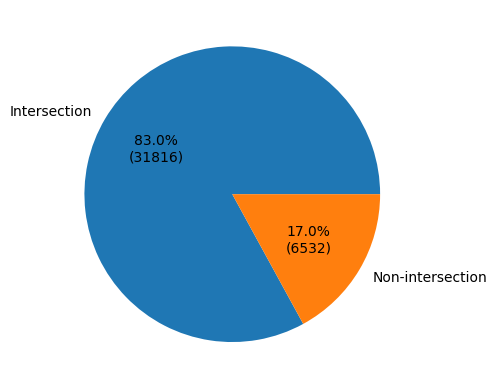

In [8]:
# Creating a pie chart to visualize number of accidents at intersections
accident_at_intersection = df['accident-at-intersection'].value_counts()
display(accident_at_intersection)

plt.pie(accident_at_intersection, labels=["Intersection", "Non-intersection"], autopct = autopct_format(accident_at_intersection), shadow = False)


### A - About 83% of accidents are at intersections

This may be a good place to concentrate our efforts on accident reduction.

## Q3

### Q - How many accidents involve e-bikes?

I want to understand the differences in accidents when e-bikes are involved vs. standard bikes. We will use another pie chart to visualize how many accidents involve e-bikes versus non-ebikes.

([<matplotlib.patches.Wedge at 0x7b0f88dae860>,
 [Text(-1.0859363435717473, 0.17533470195607104, 'Normal bike'),
  Text(1.0859363517797558, -0.1753346511197214, 'E-bike')],
 [Text(-0.5923289146754984, 0.09563711015785692, '94.9%\n(36394)'),
  Text(0.592328919152594, -0.09563708242893894, '5.1%\n(1954)')])

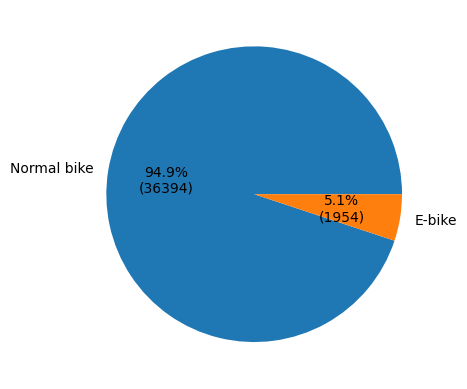

In [9]:
# Creating a pie chart to visualize porportions of the detection methods in this data
ebike = df['e-bike'].value_counts()
#display(ebike)
plt.pie(ebike, labels=["Normal bike", "E-bike"], autopct = autopct_format(ebike), shadow = False)

### A - About five percent

Around five percent of accidents involve e-bikes as either vehicle 1, 2 or 3.  That's actually more than I'd expected, and we should be able to use this information to understand the fatality risk of ebikes versus normal bikes.

## Q4

### Q - What kinds of contributing factors are causing accidents?

To know the main contributors to accidents we should sum up the various reasons we see accidents and plot them with a chart.

<Axes: ylabel='None'>

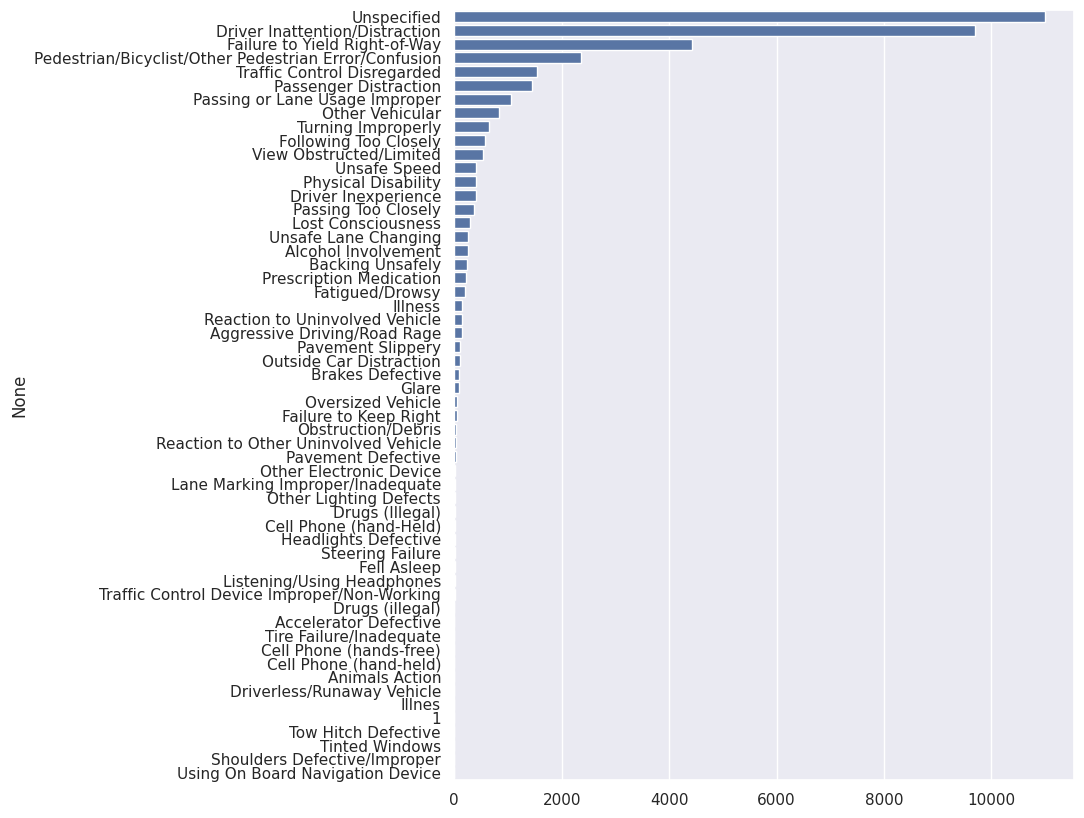

In [10]:
# use a bar plot to understand contributing factors
contributing_factors = df['contributing-factor-vehicle-1'].value_counts()
sns.set(rc={"figure.figsize":(8, 10)})
sns.barplot(y=contributing_factors.index, x=contributing_factors.values, orient='h')

### A - Inattention is the main cause of accidents

Officially, "unspecified" came in on top, but of the data points with valid values "driver inattention/distraction" was number 1.  As expected.

## Q5

### Q - What vehicles are involved most in fatalities?

<Axes: ylabel='None'>

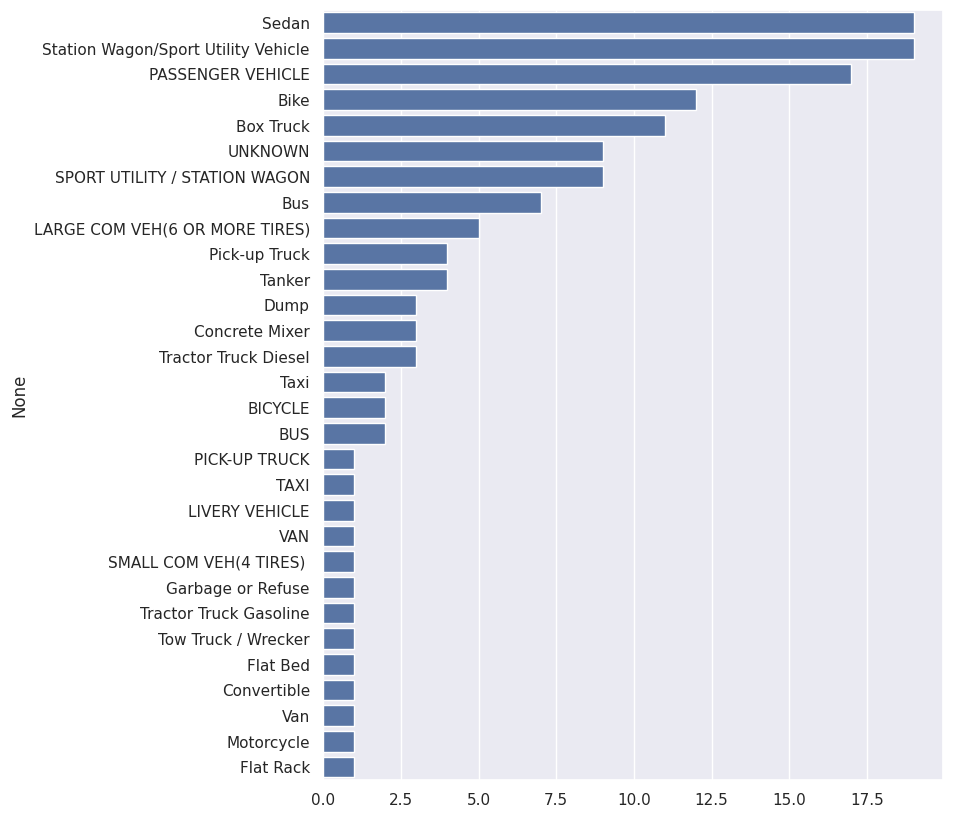

In [11]:
# use a bar plot to understand vehicles involved in fatal accidents
via_df = df[df['cyclist-fatalities'] == True]
vehicles_in_accidents = via_df['vehicle-type-code-1'].value_counts()
sns.set(rc={"figure.figsize":(8, 10)})
sns.barplot(y=vehicles_in_accidents.index, x=vehicles_in_accidents.values, orient='h')

### A - Either Sedans or Sport Utility / Station Wagons kill the most cyclists

Since SUV/Station Wagon has two different groupings we need to add those together to get the true value of SUV/SW impacts on fatalities.  We may also need to add "Sedan" with "PASSENGER VEHICLE". Since "passenger vehicle" is such a broad category it's not immediately clear if sedans or SUV/SW is responsible for the most deaths.

# Data Findings

- Deaths are relatively rare
- Accidents are clustered around central park, but are fairly dense across much of the core city.
  - Most of these accidents are at intersections.
  - Accidents at intersections comprise roughly 75% of accidents.
- Only about 5% of accidents involve e-bikes, but this is likely to grow over time.
- Inattention causes the most accidents.
- Sedans and sport utility vehicles kill the most cyclists by a wide margin. Whether this is disproportionately representative given the distribution of vehicles is unknown at this time.

# ML Pipelines

## Try to detect if an accident happened at an intersection

### Decision Tree Classifier

#### Basic Pipeline
This is a very simple decision tree pipeline, and the one I'd like to test against to see if we can improve performance.

In [12]:
x = df[['longitude', 'latitude']]
y = df['accident-at-intersection']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),             # Imputation step
    ('scaler', StandardScaler()),                            # Feature scaling
    ('classifier', DecisionTreeClassifier(random_state=42))  # Classifier
])
# Training the model
pipeline.fit(X_train, y_train)
# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "DecisionTreeClassifier")

              precision    recall  f1-score   support

       False       0.61      0.44      0.51      1309
        True       0.89      0.94      0.92      6361

    accuracy                           0.86      7670
   macro avg       0.75      0.69      0.71      7670
weighted avg       0.84      0.86      0.85      7670

MODEL: DecisionTreeClassifier
Model accuracy: 0.856
Precision: 0.890
Recall: 0.942
F1 Score: 0.915



#### Hyperparameter Tuning
We may be able to get a better result with some basic feature enhancements and hyperparameter tuning.  We will start with StratifiedKFold.

In [13]:
# get rid of all bad rows that have no lat/long
df_dtc = df.dropna(subset=['latitude', 'longitude'])
x = df_dtc[['longitude', 'latitude']]
y = df_dtc['accident-at-intersection']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_index, test_index in skf.split(x, y):
    # Splitting the data into training and testing sets for the current fold
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the pipeline
    dt_pipeline = Pipeline([
         ('scaler', StandardScaler()),                           # Feature scaling
        ('classifier', DecisionTreeClassifier(random_state=42))  # Classifier
    ])

    # Training the model on the current fold
    dt_pipeline.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = dt_pipeline.predict(X_test)

    # Evaluating the model performance
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    evaluate_model_performance(y_test, y_pred, "DecisionTreeClassifier")

# Calculate the mean of the metrics across all folds
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1 Score: {mean_f1_score}")

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "DecisionTreeClassifier with Tuning")

MODEL: DecisionTreeClassifier
Model accuracy: 0.849
Precision: 0.889
Recall: 0.935
F1 Score: 0.911

MODEL: DecisionTreeClassifier
Model accuracy: 0.849
Precision: 0.886
Recall: 0.938
F1 Score: 0.912

MODEL: DecisionTreeClassifier
Model accuracy: 0.848
Precision: 0.885
Recall: 0.938
F1 Score: 0.911

MODEL: DecisionTreeClassifier
Model accuracy: 0.856
Precision: 0.892
Recall: 0.940
F1 Score: 0.915

MODEL: DecisionTreeClassifier
Model accuracy: 0.853
Precision: 0.888
Recall: 0.942
F1 Score: 0.914

Mean Accuracy: 0.8510496970193786
Mean Precision: 0.8369642836746862
Mean Recall: 0.8510496970193786
Mean F1 Score: 0.8411942345933211
              precision    recall  f1-score   support

       False       0.60      0.42      0.50      1283
        True       0.89      0.94      0.91      6214

    accuracy                           0.85      7497
   macro avg       0.74      0.68      0.71      7497
weighted avg       0.84      0.85      0.84      7497

MODEL: DecisionTreeClassifier with Tun

Let's try StratifiedKFold as well as GridSearchCV.

In [14]:
# get rid of all bad rows that have no lat/long
df_dtc = df.dropna(subset=['latitude', 'longitude'])
x = df_dtc[['longitude', 'latitude']]
y = df_dtc['accident-at-intersection']

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),                 # Feature scaling
    ('classifier', DecisionTreeClassifier())      # Classifier placeholder
])

# Parameter grid for GridSearchCV
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=1)

# Fit GridSearchCV on the training set
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Best Estimator:", best_score)

# Predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "DecisionTreeClassifier Imbalance-Learn")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best Cross-Validation Score: 0.8325499620615885
Best Estimator: 0.8325499620615885
              precision    recall  f1-score   support

       False       0.57      0.42      0.48      1298
        True       0.88      0.93      0.91      6200

    accuracy                           0.84      7498
   macro avg       0.73      0.67      0.69      7498
weighted avg       0.83      0.84      0.83      7498

MODEL: DecisionTreeClassifier Imbalance-Learn
Model accuracy: 0.844
Precision: 0.884
Recall: 0.934
F1 Score: 0.908



#### Imbalanced-Learn

Our models aren't really improving, and it's likely the relatively small set of accidents that didn't happen at intersections has something to do with that.  Imbalanced-Learn can help with that.

In [15]:
df_dtc = df.dropna(subset=['latitude', 'longitude'])
x = df_dtc[['longitude', 'latitude']]
y = df_dtc['accident-at-intersection']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Modifying the pipeline to include SMOTE for handling imbalanced data
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),                       # Apply SMOTE to oversample minority class
    ('classifier', DecisionTreeClassifier(random_state=42))  # Classifier
])

# Training the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "DecisionTreeClassifier Imbalance-Learn")

              precision    recall  f1-score   support

       False       0.52      0.56      0.54      1298
        True       0.91      0.89      0.90      6200

    accuracy                           0.83      7498
   macro avg       0.71      0.73      0.72      7498
weighted avg       0.84      0.83      0.84      7498

MODEL: DecisionTreeClassifier Imbalance-Learn
Model accuracy: 0.835
Precision: 0.906
Recall: 0.892
F1 Score: 0.899



### Random Forest Classifier


#### Basic Pipeline

In [16]:
x = df[['longitude', 'latitude']]
y = df['accident-at-intersection']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),             # Imputation step
    ('scaler', StandardScaler()),                            # Feature scaling
    ('classifier', RandomForestClassifier(random_state=42))  # Classifier
])
# Training the model
pipeline.fit(X_train, y_train)
# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "RandomForestClassifier")

              precision    recall  f1-score   support

       False       0.69      0.32      0.43      1309
        True       0.87      0.97      0.92      6361

    accuracy                           0.86      7670
   macro avg       0.78      0.64      0.68      7670
weighted avg       0.84      0.86      0.84      7670

MODEL: RandomForestClassifier
Model accuracy: 0.859
Precision: 0.873
Recall: 0.971
F1 Score: 0.919



#### Hyperparameter Tuning

In [17]:
# get rid of all bad rows that have no lat/long
df_dtc = df.dropna(subset=['latitude', 'longitude'])
x = df_dtc[['longitude', 'latitude']]
y = df_dtc['accident-at-intersection']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))  # Classifier
])
print(pipeline.get_params().keys())
# Define the parameter grid for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [5, 12, 32],           # Number of trees
    'classifier__max_depth': [None, 10, 20, 30, 40],   # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],       # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 3, 5],         # Minimum number of samples required at each leaf node
}

# Using RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fitting the model
random_search.fit(X_train, y_train)

# Making predictions
y_pred = random_search.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "RandomForestClassifier with Hyperparameter Tuning")

dict_keys(['memory', 'steps', 'verbose', 'classifier', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])
Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

       False       0.68      0.32      0.43      1298
        True       0.87      0.97      0.92      6200

    accuracy                           0.86      7498
   macro avg       0.78      0.64      0.68      7498
weighted avg       0.84      0.86      0.83      7498

MODEL: RandomForestClassifier with Hyperparameter

#### Imbalanced-Learn

In [18]:
df_dtc = df.dropna(subset=['latitude', 'longitude'])
x = df_dtc[['longitude', 'latitude']]
y = df_dtc['accident-at-intersection']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Modifying the pipeline to include SMOTE for handling imbalanced data
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),                       # Apply SMOTE to oversample minority class
    ('classifier', RandomForestClassifier(random_state=42))  # Classifier
])

# Training the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "RandomForestClassifier Imbalanced-Learn")

              precision    recall  f1-score   support

       False       0.55      0.55      0.55      1298
        True       0.91      0.90      0.91      6200

    accuracy                           0.84      7498
   macro avg       0.73      0.73      0.73      7498
weighted avg       0.84      0.84      0.84      7498

MODEL: RandomForestClassifier Imbalanced-Learn
Model accuracy: 0.844
Precision: 0.906
Recall: 0.905
F1 Score: 0.905



### KNeighbors Classifier

#### Basic Pipeline

In [19]:
x = df[['longitude', 'latitude']]
y = df['accident-at-intersection']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),           # Imputation step
    ('scaler', StandardScaler()),                          # Feature scaling
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # Classifier
])

# Training the model
pipeline.fit(X_train, y_train)
# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "KNeighborsClassifier")

              precision    recall  f1-score   support

       False       0.50      0.17      0.25      1309
        True       0.85      0.96      0.90      6361

    accuracy                           0.83      7670
   macro avg       0.67      0.57      0.58      7670
weighted avg       0.79      0.83      0.79      7670

MODEL: KNeighborsClassifier
Model accuracy: 0.829
Precision: 0.850
Recall: 0.964
F1 Score: 0.903



#### Hyperparameter Tuning

In [20]:
# get rid of all bad rows that have no lat/long
df_dtc = df.dropna(subset=['latitude', 'longitude'])
x = df_dtc[['longitude', 'latitude']]
y = df_dtc['accident-at-intersection']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Defining the pipeline
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Parameter distribution for RandomizedSearchCV
param_dist = {
    'classifier__n_neighbors': range(1, 31),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Using RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=100, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fitting the model
random_search.fit(X_train, y_train)

# Making predictions
y_pred = random_search.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "KNeighborsClassifier with Random Search CV")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
              precision    recall  f1-score   support

       False       0.80      0.20      0.33      1298
        True       0.86      0.99      0.92      6200

    accuracy                           0.85      7498
   macro avg       0.83      0.60      0.62      7498
weighted avg       0.85      0.85      0.82      7498

MODEL: KNeighborsClassifier with Random Search CV
Model accuracy: 0.854
Precision: 0.856
Recall: 0.989
F1 Score: 0.918



#### Imbalanced-Learn

In [21]:
# get rid of all bad rows that have no lat/long
df_dtc = df.dropna(subset=['latitude', 'longitude'])
x = df_dtc[['longitude', 'latitude']]
y = df_dtc['accident-at-intersection']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Defining the pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Parameter distribution for RandomizedSearchCV
param_dist = {
    'classifier__n_neighbors': range(1, 31),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Using RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=100, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fitting the model
random_search.fit(X_train, y_train)

# Making predictions
y_pred = random_search.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "KNeighborsClassifier with Random Search CV & Imbalance-Learn")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
              precision    recall  f1-score   support

       False       0.54      0.53      0.54      1298
        True       0.90      0.90      0.90      6200

    accuracy                           0.84      7498
   macro avg       0.72      0.72      0.72      7498
weighted avg       0.84      0.84      0.84      7498

MODEL: KNeighborsClassifier with Random Search CV & Imbalance-Learn
Model accuracy: 0.840
Precision: 0.903
Recall: 0.905
F1 Score: 0.904



### SGD Classifier

#### Basic Pipeline

In [22]:
x = df[['longitude', 'latitude']]
y = df['accident-at-intersection']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),       # Imputation step
    ('scaler', StandardScaler()),                      # Feature scaling
    ('classifier', SGDClassifier(random_state=42))     # Classifier
])

# Training the model
pipeline.fit(X_train, y_train)
# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "SGD Classifier")

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      1309
        True       0.83      1.00      0.91      6361

    accuracy                           0.83      7670
   macro avg       0.41      0.50      0.45      7670
weighted avg       0.69      0.83      0.75      7670

MODEL: SGD Classifier
Model accuracy: 0.829
Precision: 0.829
Recall: 1.000
F1 Score: 0.907



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Hyperparameter Tuning

In [23]:
# get rid of all bad rows that have no lat/long
df_dtc = df.dropna(subset=['latitude', 'longitude'])
x = df_dtc[['longitude', 'latitude']]
y = df_dtc['accident-at-intersection']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the pipeline with SGDClassifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),             # Imputation step
    ('scaler', StandardScaler()),                            # Feature scaling
    ('classifier', SGDClassifier(random_state=42))           # Classifier
])

# Define the parameter grid for SGDClassifier
param_grid = {
    'classifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], # Loss functions
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],          # Regularization parameter
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],        # The penalty (aka regularization term)
    'classifier__max_iter': [1000, 2000, 3000],               # Maximum number of iterations
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best model after random search
best_pipeline = random_search.best_estimator_

# Making predictions with the best model
y_pred = best_pipeline.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "SGD with Random Search CV")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
              precision    recall  f1-score   support

       False       0.00      0.00      0.00      1298
        True       0.83      1.00      0.91      6200

    accuracy                           0.83      7498
   macro avg       0.41      0.50      0.45      7498
weighted avg       0.68      0.83      0.75      7498

MODEL: SGD with Random Search CV
Model accuracy: 0.827
Precision: 0.827
Recall: 1.000
F1 Score: 0.905



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Imbalanced-Learn (haha, this is horrible)

In [24]:
# get rid of all bad rows that have no lat/long
df_dtc = df.dropna(subset=['latitude', 'longitude'])
x = df_dtc[['longitude', 'latitude']]
y = df_dtc['accident-at-intersection']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the pipeline with SMOTE and SGDClassifier
pipeline = make_pipeline_imblearn(
    SimpleImputer(strategy='mean'),       # Imputation step
    StandardScaler(),                      # Feature scaling
    SMOTE(random_state=42),                # Apply SMOTE to oversample minority class
    SGDClassifier(random_state=42)         # Classifier
)

# Training the model with the modified pipeline
pipeline.fit(X_train, y_train)
# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))
evaluate_model_performance(y_test, y_pred, "SGD Imbalanced-Learn")

              precision    recall  f1-score   support

       False       0.18      0.82      0.29      1298
        True       0.85      0.20      0.33      6200

    accuracy                           0.31      7498
   macro avg       0.51      0.51      0.31      7498
weighted avg       0.73      0.31      0.32      7498

MODEL: SGD Imbalanced-Learn
Model accuracy: 0.311
Precision: 0.846
Recall: 0.204
F1 Score: 0.329



## Prediction results - Accident at Intersection

| Classifier | Pipeline Profile | Accuracy | Precision | Recall | F1 Score |
|------------|------------------|----------|-----------|--------|----------|
|DecisionTreeClassifier| Basic | 0.856 | 0.890 | 0.942 | 0.915 |
|DecisionTreeClassifier| Hyperparameter Tuning | 0.853 | 0.888 | 0.942 | 0.914|
|DecisionTreeClassifier| Imbalance-Learn |0.835 |0.906 |0.892 | 0.899|
|**RandomForestClassifier**| Basic |**0.859** | 0.873|0.971 | 0.919|
|**RandomForestClassifier**| Hyperparameter Tuning | **0.856** | 0.871| 0.969 | 0.918 |
|RandomForestClassifier| Imbalance-Learn | 0.844 | 0.906 | 0.905 | 0.905 |
|KNeighborsClassifier | Basic |0.829 | 0.850 | 0.964 | 0.903 |
|KNeighborsClassifier | Hyperparameter Tuning | 0.854 | 0.856 | 0.989 | 0.918 |
|KNeighborsClassifier | Imbalance-Learn | 0.840 | 0.903 | 0.905 | 0.904 |
|SGDClassifier | Basic | 0.829 | 0.829 | 1.000 | 0.907 |
|SGDClassifier | Hyperparameter Tuning | 0.827 | 0.827 | 1.000 | 0.905 |
|SGDClassifier | Imbalance-Learn | 0.311 | 0.846 | 0.204 | 0.329 |

I really enjoyed testing these 4 different classifiers, and I learned a lot about feature classification with this exercise. Overall my favorite classifier was the RandomForestClassifier because it provided the highest accuracy.  I also liked the KNeighborsClassifier as I was able to get the most improvement with Hyperparameter Tuning - from .829 accuracy up to .854.  I didn't have much success with imbalance learn, but after trying a number of tweaks I came to the conclusion that imbalance learn would likely work better if I had more test data.

Instinctively I wanted to add more features, but I'm glad I left it at just the latitude and longitude - as instructed in the homework assignment. The two simple inputs and binary classification output gave me a very simple use case, which allowed me to understand more about the different classifiers.

### Best Classifiers


#### Best Performance - RandomForestClassifier

Overall the RandomForestClassifier worked the best, yielding the best accuracy.  Precision was acceptable, although there were some other models that did better. It's probably due to the fact that I'm inexperienced with hyperparameter tuning but I couldn't get much of an improvement with RandomForestClassifier.  Even after several iterations of tweaking the best I could do was 0.856.

#### Most Improved - KNeighborsClassifier

I was struck, after reading the strategy behind KNeighborsClassifier, how clever it is. I believe a KNeighborsClassifier could out-perform the RandomForestClassifier if I had enough time to tune it, but the best I could do was get the two classifiers to perform about equally.

#### Best Personality - SGDClassifier

I tried the SGDClassifier and actually laughed out loud when I saw the results of imbalance-learn. If that doesn't qualify for best personality I don't know what does. That being said, it really didn't perform well. My guess is that the linear component of SGD got thrown out of alignment with the large number of "not an intersection" data points added to the training set.

## Enhanced accident-at-intersection detection


In order to attempt to get better predictions I'd like to add some features.  I set a baseline using only GPS data, but want to include other features to see if we can make the AI models work better.

### Features to engineer



* contributing-factor-vehicle-1
 * I think it's possible that the factors contributing to the accident will play a role in whether the accident happens at an intersection.  This is a text description field, and will need to be encoded.
 * Based on the large number of possibilities it seems like we should hash these values in some mechanism, perhaps by "distracted driving", "vehicle failure" or "other".
 * Maybe we could use Sentence-Transformers? Some other transformer?
*   vehicle-type-code-1
 * It seems unlikely that the vehicle type would have a strong predictive capacity for determining if an accident happened at an intersection, but that's just my guess. I don't have any way to back that up. Since this is a feature we have available, it seems like it's worth trying in case it turns out to be a stronger predictor than expected.
 * Once again, there are a large number of categorical values here we will need to represent numerically.
 * Again, let's try to hash these values to see if we can use the data to help predict if an accident happened at an intersection.



### Unit testing plans

#### Comparison to models without the features

Comparing the metrics of the models without the extra features to the models with the features will be the best indicator to determine model enhancement. I'd specifically like to see the accuracy go up, but would be satisfied with enhancements to the other metrics.

#### Comparison based on different methods of engineering

The features to be engineered could be modeled in a few different ways.  I'd like to try engineering them in a variety of ways, and comparing these to each other and using the best performing engineered metric(s).

#### Validating engineering code is correct

When we engineer features we need to make sure that the code is working. Without unit testing we may accidentally classify a single data row into more than one category simply by virtue of missing a category, or adding a category to more than one boolean flag.

### Engineered Features

#### Categorize 'contributing-factor-vehicle-1'

This will be a little like one-hot-encoding, but we need to be a little smarter than simply turning every category into a separate feature. The fine-grained categories will be split into higher-order categories and manually encoded.

In [30]:
# split contributing-factor-vehicle-1 into categories
# *** distracted driving - driver of motor vehicle was distracted or inattentive in some way
# *** bad driving - the driver caused the accident because they were inexperienced or driving in an unsafe way
# *** impaired driving - alcohol, drugs, illness or some other reason the driver was impaired
# *** other - all other reasons, which can include everything from broken street lights to mechanical failures
distracted_driving_categories = ['Cell Phone (hand-Held)', 'Driver Inattention/Distraction', 'Listening/Using Headphones', 'Outside Car Distraction',
                                 'Passenger Distraction', 'Using On Board Navigation Device']
bad_driving_categories = ['Aggressive Driving/Road Rage', 'Backing Unsafely', 'Driver Inexperience', 'Failure to Keep Right', 'Failure to Yield Right-of-Way',
                          'Following Too Closely', 'Passing or Lane Usage Improper', 'Passing Too Closely', 'Traffic Control Disregarded',
                          'Turning Improperly', 'Unsafe Lane Changing', 'Unsafe Speed']
impaired_driving_categories = ['Alcohol Involvement', 'Drugs (illegal)', 'Fatigued/Drowsy', 'Fell Asleep', 'Illness', 'Lost Consciousness', 'Physical Disability',
                               'Prescription Medication']

df['fx-cfv1-distracted-driving'] = df['contributing-factor-vehicle-1'].apply(lambda x: 1 if x in distracted_driving_categories else 0)
df['fx-cfv1-bad-driving'] = df['contributing-factor-vehicle-1'].apply(lambda x: 1 if x in bad_driving_categories else 0)
df['fx-cfv1-impaired-driving'] = df['contributing-factor-vehicle-1'].apply(lambda x: 1 if x in impaired_driving_categories else 0)
df['fx-cfv1-other'] = np.where((df['fx-cfv1-distracted-driving'] == 0) & (df['fx-cfv1-bad-driving'] == 0) & (df['fx-cfv1-impaired-driving'] == 0), 1, 0)

# unit test
# - add up all the manually one-hot-encoded categories and make sure they total the number of rows
assert df['fx-cfv1-distracted-driving'].sum() + df['fx-cfv1-bad-driving'].sum() + df['fx-cfv1-impaired-driving'].sum() + df['fx-cfv1-other'].sum() == df.shape[0]

#### Categorize 'vehicle-type-code-1'

Again, we will do a form of one-hot-encoding by identifying higher order categories and creating binary features to capture this information.

In [31]:
# split vehicle-type-code-1 into categories
# *** car - any of various types of cars
# *** truck - any of various types of trucks, which can include everything from a small pickup to a tractor trailer
# *** suv_van - midsize vehicles like SUVs, vans, station wagons
# *** other - all other vehicles, or 'UNKNOWN' vehicles

car   = ['2 dr sedan', '4 dr sedan', 'Convertible', 'LIVERY VEHICLE', 'PASSENGER VEHICLE', 'Sedan', 'Taxi', 'TAXI', 'YELLO', 'YELLOW TAX']
truck = ['BOX', 'Box Truck', 'Concrete Mixer', 'DELIV', 'delv', 'Dump', 'DODGE RAM', 'dumps', 'Garbage or Refuse', 'LARGE COM VEH(6 OR MORE TIRES)',
         'Pick-up Truck', 'PICK-UP TRUCK', 'PK', 'Tow Truck / Wrecker', 'Tractor Truck Diesel', 'Tractor Truck Gasoline']
suv_van   = ['SPORT UTILITY / STATION WAGON', 'Station Wagon/Sport Utility Vehicle', 'VAN']

df['fx-vtc1-car'] = df['vehicle-type-code-1'].apply(lambda x: 1 if x in car else 0)
df['fx-vtc1-truck'] = df['vehicle-type-code-1'].apply(lambda x: 1 if x in truck else 0)
df['fx-vtc1-suv-van'] = df['vehicle-type-code-1'].apply(lambda x: 1 if x in suv_van else 0)
df['fx-vtc1-other'] = np.where((df['fx-vtc1-car'] == 0) & (df['fx-vtc1-truck'] == 0) & (df['fx-vtc1-suv-van'] == 0), 1, 0)

# unit test
# - add up all the manually one-hot-encoded categories and make sure they total the number of rows
assert df['fx-vtc1-car'].sum() + df['fx-vtc1-truck'].sum() + df['fx-vtc1-suv-van'].sum() + df['fx-vtc1-other'].sum() == df.shape[0]

# Data Science Tasks

## Task 1: Feature engineering - Add feature for 'type-by-bike'

I'd like to have 4 possible values for a feature called 'type-by-bike'. The values are as follows:

'Bike injury'
'Bike fatality'
'E-bike injury'
'E-bike fatality'


## Task 2: Feature Engineering - Consolidate duplicate vehicle-type-code-X fields

Based on data analysis it appears there are duplicates in the vehicle-type-code features. We can probably get rid of those using case-insensitive compares or changing all case to lower.

## Task 3: Train test split / with golden holdout

We should keep 10% of data as a golden holdout, Train with 70% and test with 20%.

## Task 4: Establish an initial pipeline

- We have NaN data for on-street, off-street and cross street features. We should do something about those.
- It makes sense to create a new feature called "Day of week" we can extract based on the date. We could do this with a column transformer. This will be important based on the fact that accidents may vary based on day of week
- We should also make a new feature called "weekday" that is a boolean feature. M-F should evaluate to True, S-S evaluates to False.

## Task 5: Model fitting and evaluation

Assumptions:
  - Trying to create a classification model to separate deaths from injuries will be difficult due to the relatively scarce number of deaths.
  - Sufficient e-bike accidents exist to make some determinations about the risk of injury vs. death with e-bikes versus normal bikes.